# Exercise 1: Regression: Predict Car Performance

## 1. Download dataset

In [2]:
!gdown 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 28.3MB/s]


## 2. Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 3. Setting random functions

To make the output unchanged each time we run all the notebook, seed need to be set

In [4]:
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

## 4. Set device

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 5. Read dataset

In [6]:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

## 6. Preprocessing data

### Split to X and y

In [7]:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

### Split to train/val/test

In [8]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size = val_size,
    random_state = random_state,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = random_state,
    shuffle = is_shuffle
)

### Normalize data

In [9]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## 7. Build DataLoader

In [10]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [11]:
batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 8. Build MLP network

In [12]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super().__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    out = self.output(x)

    return out.squeeze(1)

In [13]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

## 9. Declare loss and optimizer function

In [14]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## 10. Build R^2 calculating function

In [15]:
def r_squared(y_true, y_pred):
  y_true = torch.Tensor(y_true).to(device)
  y_pred = torch.Tensor(y_pred).to(device)

  mean_true = torch.mean(y_true)
  ss_tot = torch.sum((y_true - mean_true) ** 2)
  ss_res = torch.sum((y_true - y_pred) ** 2)

  r2 = 1 - (ss_res / ss_tot)

  return r2

## 11. Train model

In [16]:
epochs = 100

train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  val_target = []
  train_predict = []
  val_predict = []

  model.train()

  for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)

    optimizer.zero_grad()

    outputs = model(X_samples)

    train_predict += outputs.tolist()
    train_target += y_samples.tolist()

    loss = criterion(outputs, y_samples)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  train_r2.append(r_squared(train_target, train_predict))

  model.eval()

  val_loss = 0.0

  with torch.no_grad():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples.to(device)
      y_samples = y_samples.to(device)

      outputs = model(X_samples)

      val_predict += outputs.tolist()
      val_target += y_samples.tolist()

      loss = criterion(outputs, y_samples)
      val_loss += loss.item()

  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  val_r2.append(r_squared(val_target, val_predict))

  print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 282.769	Validation loss: 88.672

EPOCH 2:	Training loss: 137.669	Validation loss: 72.346

EPOCH 3:	Training loss: 71.007	Validation loss: 19.143

EPOCH 4:	Training loss: 25.083	Validation loss: 196.176

EPOCH 5:	Training loss: 96.139	Validation loss: 20.444

EPOCH 6:	Training loss: 17.765	Validation loss: 9.444

EPOCH 7:	Training loss: 18.486	Validation loss: 14.535

EPOCH 8:	Training loss: 37.859	Validation loss: 37.427

EPOCH 9:	Training loss: 17.133	Validation loss: 38.134

EPOCH 10:	Training loss: 22.991	Validation loss: 41.183

EPOCH 11:	Training loss: 26.723	Validation loss: 20.063

EPOCH 12:	Training loss: 9.852	Validation loss: 5.594

EPOCH 13:	Training loss: 15.143	Validation loss: 16.025

EPOCH 14:	Training loss: 12.213	Validation loss: 12.023

EPOCH 15:	Training loss: 14.222	Validation loss: 7.731

EPOCH 16:	Training loss: 10.845	Validation loss: 18.904

EPOCH 17:	Training loss: 12.312	Validation loss: 14.885

EPOCH 18:	Training loss: 15.474	Validati

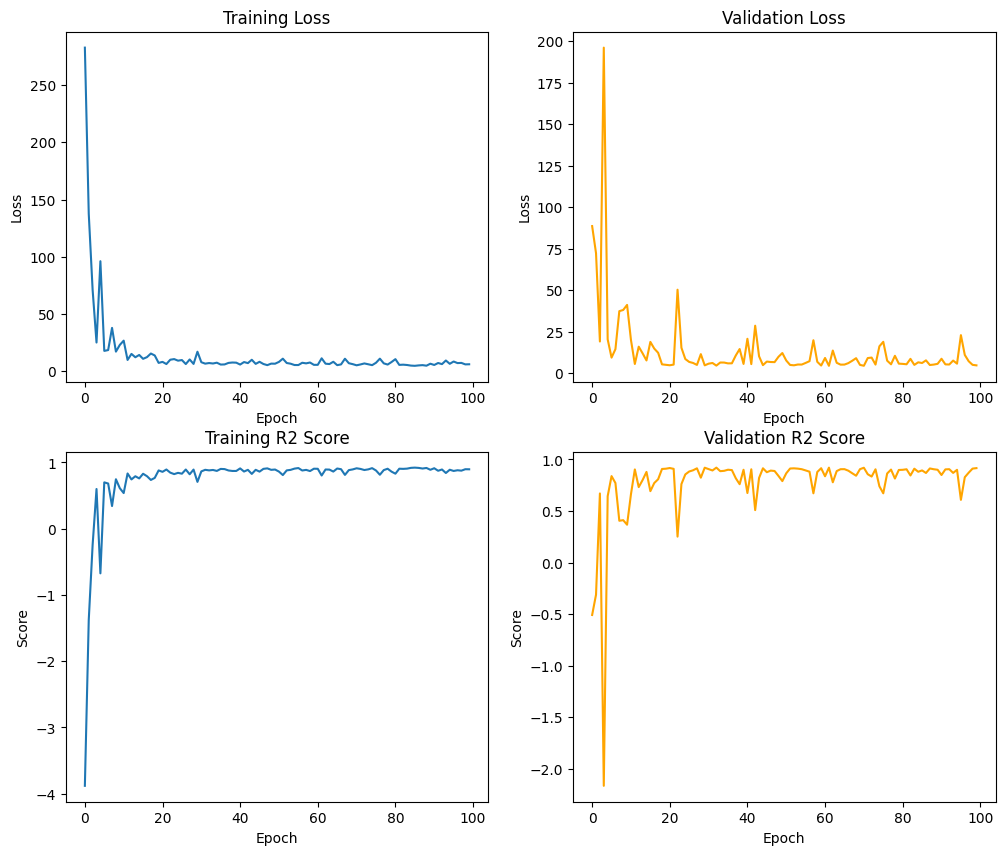

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_r2)
ax[1, 0].set(xlabel='Epoch', ylabel='Score')
ax[1, 0].set_title('Training R2 Score')

ax[1, 1].plot(val_r2, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Score')
ax[1, 1].set_title('Validation R2 Score')

plt.show()

## 12. Evaluate model

In [17]:
model.eval()

with torch.no_grad():
  y_hat = model(X_test)

  test_set_r2 = r_squared(y_hat, y_test)

  print('Evaluation on test set')
  print(f'R2: {test_set_r2}')

Evaluation on test set
R2: 0.8417800068855286


# Exercise 2: Classification with nonlinear data

## 1. Download dataset

In [18]:
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 18.4MB/s]


## 2. Import libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 3. Set device and random seed

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

## 4. Read dataset

In [25]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()

X, y = data['X'], data['labels']

In [26]:
print(X.shape, y.shape)

(300, 2) (300,)


## 5. Split to train/val/test

In [27]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size = val_size,
    random_state = random_state,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = random_state,
    shuffle = is_shuffle
)

## 6. Normalize data

In [29]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

## 7. Build DataLoader

In [30]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [31]:
batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 8. Build MLP Network

In [32]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.relu = nn.ReLU()
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    out = self.output(x)

    return out.squeeze(1)

In [33]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

## 9. Declare loss and optimizer function

In [34]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## 10. Build accuracy function

In [37]:
def compute_accuracy(y_hat, y_true):
  _, y_hat = torch.max(y_hat, dim=1)
  correct = (y_hat == y_true).sum().item()
  accuracy = correct / len(y_true)

  return accuracy

## 11. Train model

In [38]:
epochs = 100

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  val_target = []
  train_predict = []
  val_predict = []

  model.train()

  for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)

    optimizer.zero_grad()

    outputs = model(X_samples)

    loss = criterion(outputs, y_samples)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    train_predict.append(outputs.detach().cpu())
    train_target.append(y_samples.cpu())

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  train_predict = torch.cat(train_predict)
  train_target = torch.cat(train_target)

  train_acc = compute_accuracy(train_predict, train_target)
  train_accs.append(train_acc)

  model.eval()

  val_loss = 0.0

  with torch.no_grad():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples.to(device)
      y_samples = y_samples.to(device)

      outputs = model(X_samples)

      val_predict.append(outputs.cpu())
      val_target.append(y_samples.cpu())

      loss = criterion(outputs, y_samples)
      val_loss += loss.item()

  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  val_predict = torch.cat(val_predict)
  val_target = torch.cat(val_target)

  val_acc = compute_accuracy(val_predict, val_target)
  val_accs.append(val_acc)

  print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 0.939	Validation loss: 0.864

EPOCH 2:	Training loss: 0.750	Validation loss: 0.815

EPOCH 3:	Training loss: 0.715	Validation loss: 0.799

EPOCH 4:	Training loss: 0.689	Validation loss: 0.791

EPOCH 5:	Training loss: 0.670	Validation loss: 0.780

EPOCH 6:	Training loss: 0.654	Validation loss: 0.747

EPOCH 7:	Training loss: 0.646	Validation loss: 0.724

EPOCH 8:	Training loss: 0.616	Validation loss: 0.704

EPOCH 9:	Training loss: 0.616	Validation loss: 0.694

EPOCH 10:	Training loss: 0.610	Validation loss: 0.666

EPOCH 11:	Training loss: 0.577	Validation loss: 0.666

EPOCH 12:	Training loss: 0.596	Validation loss: 0.642

EPOCH 13:	Training loss: 0.556	Validation loss: 0.625

EPOCH 14:	Training loss: 0.537	Validation loss: 0.608

EPOCH 15:	Training loss: 0.521	Validation loss: 0.604

EPOCH 16:	Training loss: 0.530	Validation loss: 0.587

EPOCH 17:	Training loss: 0.511	Validation loss: 0.566

EPOCH 18:	Training loss: 0.498	Validation loss: 0.569

EPOCH 19:	Training

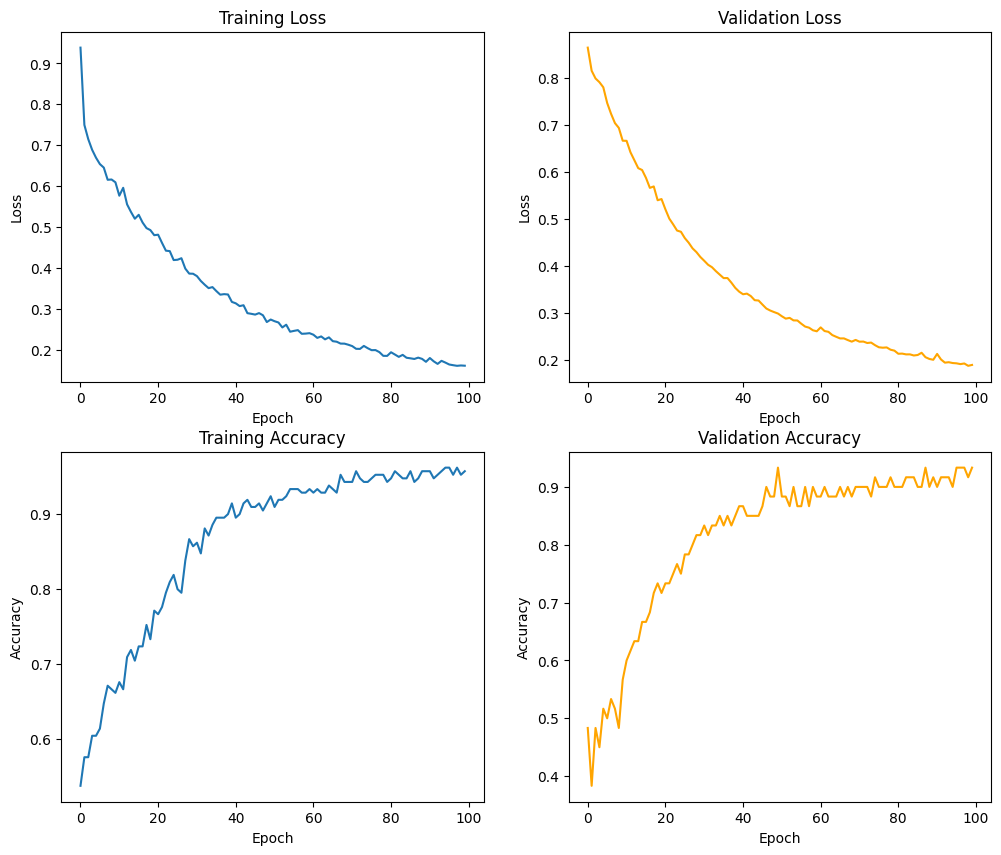

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## 12. Evaluate model

In [40]:
test_target = []
test_predict = []

model.eval()

with torch.no_grad():
  for X_samples, y_samples in test_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)

    outputs = model(X_samples)

    test_predict.append(outputs.cpu())
    test_target.append(y_samples.cpu())

  test_predict = torch.cat(test_predict)
  test_target = torch.cat(test_target)

  test_acc = compute_accuracy(test_predict, test_target)

  print('Evaluation on test set:')
  print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.9333333333333333


# Exercise 3: Classify sensiment on image

## 1. Download dataset

In [43]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=04a35c9d-d369-4dfb-9e19-32ddcfd73f8f
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 36.6MB/s]


In [44]:
!unzip -q '/content/FER-2013.zip'

## 2. Import libraries

In [45]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 3. Set random seed and device

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
  torch.cuda.manual_seed(random_state)

## 4. Read number of class in dataset

In [48]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

## 5. Build DataLoader

In [49]:
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)

img_height, img_width = (128, 128)
print(f'Image Height: {img_height}')
print(f'Image Width: {img_width}')

Image Height: 128
Image Width: 128


In [50]:
class ImageDataset(Dataset):
  def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
    self.resize = Resize((img_height, img_width))
    self.norm = norm
    self.split = split
    self.train_ratio = train_ratio
    self.img_dir = img_dir
    self.label2idx = label2idx
    self.img_paths, self.img_labels = self.read_img_files()

    if split in ['train', 'val'] and 'train' in img_dir.lower():
      train_data, val_data = train_test_split(
          list(zip(self.img_paths, self.img_labels)),
          train_size=train_ratio,
          random_state=random_state,
          stratify=self.img_labels
      )

      if split == 'train':
        self.img_paths, self.img_labels = zip(*train_data)
      elif split == 'val':
        self.img_paths, self.img_labels = zip(*val_data)

  def read_img_files(self):
    img_paths = []
    img_labels = []

    for cls in self.label2idx.keys():
      for img in os.listdir(os.path.join(self.img_dir, cls)):
        img_paths.append(os.path.join(self.img_dir, cls, img))

        img_labels.append(cls)

    return img_paths, img_labels

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    cls = self.img_labels[idx]
    img = self.resize(read_image(img_path))
    img = img.type(torch.float32)
    label = self.label2idx[cls]

    if self.norm:
      img = (img/127.5)-1

    return img, label

In [51]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

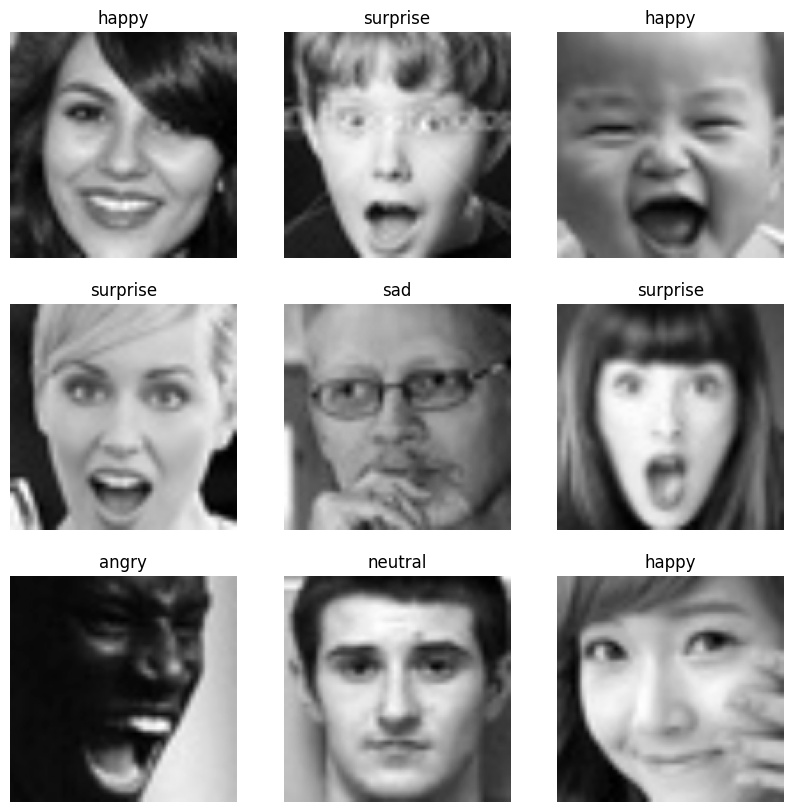

In [55]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  minv = image_batch[i].numpy().min()
  maxv = image_batch[i].numpy().max()
  plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
  label = label_batch[i]
  plt.title(idx2label[label.item()])
  plt.axis("off")

## 6. Build MLP network

In [56]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims*4)
    self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
    self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.linear3(x)
    x = F.relu(x)
    out = self.output(x)
    return out.squeeze(1)

In [57]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

### 7. Declare loss and optimizer function

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## 8. Build accuracy function

In [59]:
def compute_accuracy(y_hat, y_true):
  _, y_hat = torch.max(y_hat, dim=1)
  correct = (y_hat == y_true).sum().item()
  accuracy = correct / len(y_true)

  return accuracy

## 9. Train model

In [61]:
epochs = 10

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  val_target = []
  train_predict = []
  val_predict = []

  model.train()

  for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)

    optimizer.zero_grad()

    outputs = model(X_samples)

    loss = criterion(outputs, y_samples)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    train_predict.append(outputs.detach().cpu())
    train_target.append(y_samples.cpu())

  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  train_predict = torch.cat(train_predict)
  train_target = torch.cat(train_target)

  train_acc = compute_accuracy(train_predict, train_target)
  train_accs.append(train_acc)

  model.eval()

  val_loss = 0.0

  with torch.no_grad():
    for X_samples, y_samples in val_loader:
      X_samples = X_samples.to(device)
      y_samples = y_samples.to(device)

      outputs = model(X_samples)

      val_predict.append(outputs.cpu())
      val_target.append(y_samples.cpu())

      loss = criterion(outputs, y_samples)
      val_loss += loss.item()

  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  val_predict = torch.cat(val_predict)
  val_target = torch.cat(val_target)

  val_acc = compute_accuracy(val_predict, val_target)
  val_accs.append(val_acc)

  print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 1.691	Validation loss: 1.687

EPOCH 2:	Training loss: 1.669	Validation loss: 1.671

EPOCH 3:	Training loss: 1.653	Validation loss: 1.660

EPOCH 4:	Training loss: 1.639	Validation loss: 1.650

EPOCH 5:	Training loss: 1.628	Validation loss: 1.644

EPOCH 6:	Training loss: 1.618	Validation loss: 1.637

EPOCH 7:	Training loss: 1.609	Validation loss: 1.632

EPOCH 8:	Training loss: 1.601	Validation loss: 1.626

EPOCH 9:	Training loss: 1.591	Validation loss: 1.620

EPOCH 10:	Training loss: 1.583	Validation loss: 1.620


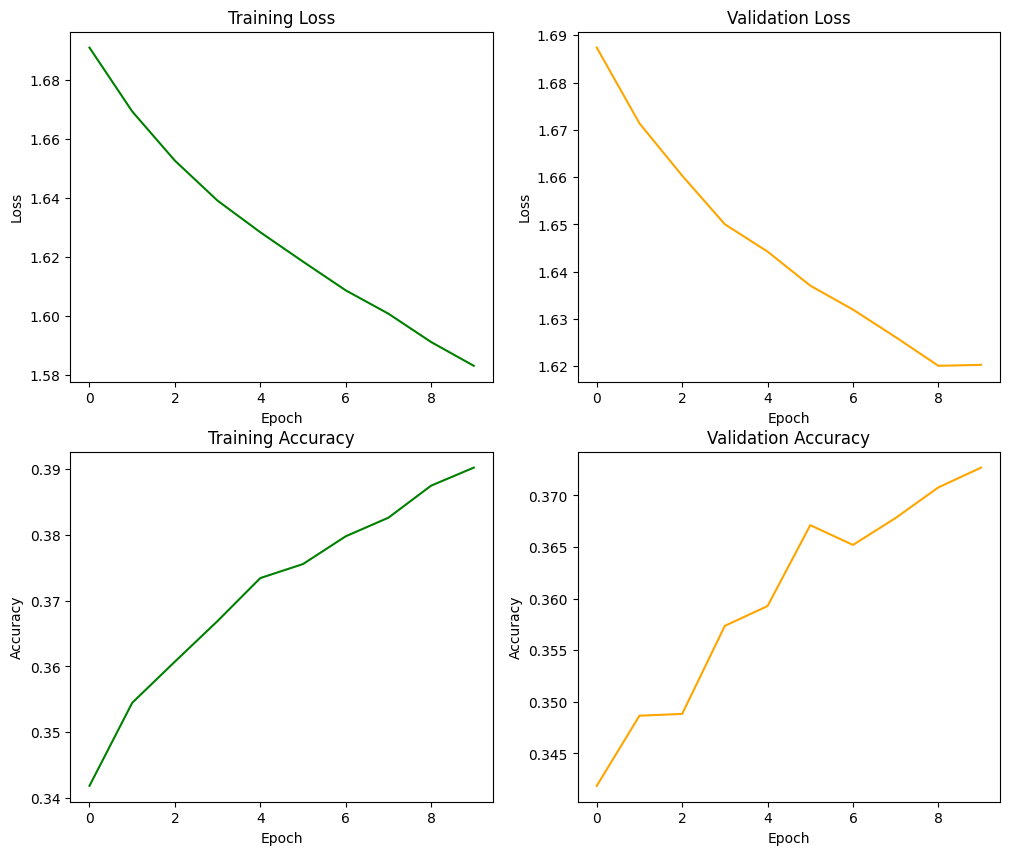

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## 10. Evaluate model

In [63]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    val_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {val_acc}')

Evaluation on test set:
Accuracy: 0.3853441069935915
